# YOLO Object detector

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pickle
import math
import time

Keras

In [2]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


## Pickle handler

In [3]:
class ModelSaver:
    def __init__(self, name = 'model', model = None):
        self.model = model
        self.fileName = name + '.pickle'
    def save(self, model = None):
        if (model == None):
            model = self.model
        pickle.dump(model, open(self.fileName, 'wb'))
    def load(self):
        model = pickle.load(open(self.fileName, 'rb'))
        return model

## Loading data

In [4]:
path = './data/signs/'
data = ModelSaver(path + 'train-test-normalized').load()

In [5]:
for key in data.keys():
    data[key] = np.array(data[key])

In [6]:
data['yTrain'].shape

(3840, 15, 15, 5)

In [7]:
xTrain = data['xTrain']
yTrain = data['yTrain']
xTest = data['xTest']
yTest = data['yTest']

xValidation = xTest[:800]
yValidation = yTest[:800]

In [8]:
def showImageWithGrid(x, grid): 
    low, high = np.min(x), np.max(x)
    img = (x - low) / (high - low)
    fig,ax = plt.subplots(1)
    fig.set_size_inches(5, 5)
    ax.imshow(img.astype('float32'), cmap=plt.get_cmap('gray_r'))
    
    gridSize = 100.0 / 15
    
    ax.vlines([ gridSize * i for i in range(1, 15)], 0, 99  )
    ax.hlines([ gridSize * i for i in range(1, 15)], 0, 99  )
    
    for i in range(0, 15):
        for j in range(0, 15):
            if (grid[i][j][0] > 0.2):
                sign = grid[i][j]
                w, h = sign[3] * gridSize, sign[4] * gridSize
                x, y = i * gridSize + sign[1] * gridSize - w / 2, j * gridSize + sign[2] * gridSize - h / 2
                rect = patches.Rectangle((x, y), w, h,
                                         linewidth=1,edgecolor='r',facecolor='none')
                rect.set_zorder(10)
                ax.add_patch(rect)
    
    plt.show()

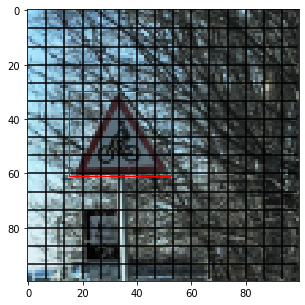

In [9]:
showImageWithGrid(xTrain[0], yTrain[0])

## Model

In [16]:
def modelLoss(yTrue, yPred):
    yTrue, yPred = K.reshape(yTrue, (K.shape(yTrue)[0], 15 * 15, 5)), K.reshape(yPred, (K.shape(yTrue)[0], 15 * 15, 5))
    results = K.switch(
        K.equal(yTrue[:, :, 0], 0), 
        K.binary_crossentropy(yPred[:, :, 0], yTrue[:, :, 0]),
        K.binary_crossentropy(yPred[:, :, 0], yTrue[:, :, 0]) +
        K.sum(K.square(yTrue - yPred), axis=2))
    return K.reshape(results, (K.shape(yTrue)[0], 15, 15))

def iou (a, b):
    ax1, ax2, ay1, ay2 = a[0] - a[2] / 2, a[0] + a[2] / 2, a[1] - a[3] / 2, a[1] + a[3] / 2
    bx1, bx2, by1, by2 = b[0] - b[2] / 2, b[0] + b[2] / 2, b[1] - b[3] / 2, b[1] + b[3] / 2
    x1, x2 = max(ax1, bx1), min(ax2, bx2)
    y1, y2 = max(ay1, by1), min(ay2, by2)
    intersection = (x2 - x1) * (y2 - y1)
    union = a[2] * a[3] + b[2] * b[3] - intersection
    print(intersection, union)
    return intersection / union

def ious (a, b):
    axy = a[..., -4:-2]
    awh = a[..., -2:]
    awh_half = awh / 2
    axy1 = axy - awh_half
    axy2 = axy + awh_half
    
    bxy = b[..., -4:-2]
    bwh = b[..., -2:]
    bwh_half = bwh / 2
    bxy1 = bxy - bwh_half
    bxy2 = bxy + bwh_half
    
    
    xy1 = K.maximum(axy1, bxy1)
    xy2 = K.minimum(axy2, bxy2)
    
    intersect_wh = K.maximum(xy2 - xy1, 0.)
    
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    a_area = awh[..., 0] * awh[..., 1]
    b_area = bwh[..., 0] * bwh[..., 1]
    
    iou = intersect_area / (a_area + b_area - intersect_area)
    return iou
    

def loss(yTrue, yPred):
    objectMask = K.cast(K.greater(yTrue[..., 0], 0.5), 'float32')
    loss = 0
    
    dXY = np.reshape([[i, j] for i in range(0, 15) for j in range (0, 15) ], (15, 15, 2))
    dPred = np.zeros((15, 15, 5))
    dPred[..., 1:3] += dXY
    dPred = K.constant(dPred)
    
    m = K.shape(yPred)[0] 
    mask = tf.TensorArray('float32', size=1, dynamic_size=True)
    def calculateIOUS(i, mask):
        trueBox = tf.boolean_mask((yTrue + dPred)[i], K.cast(objectMask[i], 'bool'))
        cTrueBox = K.shape(trueBox)[0]
        boxIous = tf.TensorArray('float32', size=1, dynamic_size=True)
        def calculateIOU(j, boxIous):
            score = ious(yPred[i] + dPred, trueBox[j])
            boxIous = boxIous.write(j, score)
            return j + 1, boxIous
        tf.while_loop(lambda j, _: j < cTrueBox, calculateIOU, [0, boxIous])
        boxIous = boxIous.stack()
        best = K.max(boxIous, axis=0)
        mask = mask.write(i, K.cast(1 - best, 'float32'))
        return i + 1, mask
    tf.while_loop(lambda i, _: i < m, calculateIOUS, [0, mask])
    
    mask = mask.stack()
    boxLossScale = 2 - yTrue[...,2:3]*yTrue[...,3:4]
    
    confidencesRatio = K.sum(yTrue[..., 0]) / K.cast(m, 'float32') / 225.0
    
    xyLoss =  objectMask * K.sum(K.binary_crossentropy(yTrue[..., 1:3], yPred[..., 1:3]), axis=-1)
    whLoss =  objectMask * K.sum(K.square(yTrue[..., 3:5] - yPred[..., 3:5]), axis=-1)
    confidence1Loss = objectMask * K.binary_crossentropy(yTrue[..., 0], yPred[..., 0]) * confidencesRatio
    confidence0Loss = (1 - objectMask) * mask * K.binary_crossentropy(yTrue[..., 0], yPred[..., 0]) / confidencesRatio
        
    loss += K.sum(whLoss)
    loss += K.sum(xyLoss)
    loss += K.sum(confidence1Loss)
    loss += K.sum(confidence0Loss)
    return loss / K.cast(m, 'float32')

class YoloCnn:
    def __init__(self):
        self.model = self.generateModel()
        self.model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
        
    def generateModel(self):
        inputShape = (100, 100, 3)
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=inputShape))
        model.add(MaxPool2D(pool_size=2)) # output shape is (50, 50, 32)
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=2)) # output shape is (25, 25, 16)
        model.add(Conv2D(32, kernel_size=(11, 11), activation='relu')) # output shape is (15, 15, 32)
        model.add(Conv2D(300, kernel_size=(1, 1), activation='relu')) # output shape is (15, 15, 300)
        model.add(Conv2D(100, kernel_size=(1, 1), activation='relu')) # output shape is (15, 15, 100)
        model.add(Conv2D(5, kernel_size=(1, 1), activation='relu')) # output shape is (15, 15, 5)
        #Perhaps a custom activation?
        return model
    
    def clone(self):
        cnn = YoloCnn()
        cnn.model = self.model
        return cnn

    def train(self, x, y, xV, yV, epochs=12):
        start = time.time()
        self.history = self.model.fit(
            x, y, epochs=epochs,
            batch_size=9,
            validation_data = (xV, yV),
            verbose=2)
        end = time.time()
        print('Training model took', int(end - start), 's')
    
    def evaluate(self, x, y):
        print('Loss:', self.model.evaluate(x, y, verbose=0)[0])
        
    def predict(self, x):
        prediction = self.model.predict(np.array([x]))[0]
        prediction[6, 9, 0] = 1
        showImageWithGrid(x, prediction)
        return prediction
    
    def load(self, path):
        self.model = load_model(path)

In [162]:
class SimpleYoloCnn:
    def __init__(self):
        self.model = self.generateModel()
        self.model.compile(optimizer='adam', loss=self.loss, metrics=['accuracy'])
        
    def generateModel(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=7, padding='same', activation='relu', input_shape=(100, 100, 3)))
        model.add(MaxPool2D(pool_size=2))
        model.add(Conv2D(32, kernel_size=4, padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dense(15*15, activation='softmax')) #hyperbolic tangent?
        return model
    
    def clone(self):
        cnn = SimpleYoloCnn()
        cnn.model = self.model
        return cnn

    def train(self, x, y, xV, yV, epochs=12):
        y = np.reshape(y[..., 0], (y.shape[0], 15 * 15))
        yV = np.reshape(yV[..., 0], (yV.shape[0], 15 * 15))
        start = time.time()
        self.history = self.model.fit(
            x, y, epochs=epochs,
            batch_size=9,
            validation_data = (xV, yV),
            verbose=2)
        end = time.time()
        print('Training model took', int(end - start), 's')
    
    def evaluate(self, x, y):
        y = np.reshape(y[..., 0], (y.shape[0], 15 * 15))
        print('Loss:', self.model.evaluate(x, y, verbose=0)[0])
        
    def predict(self, x):
        print('hello')
        prediction = self.model.predict(np.array([x]))[0]
        prediction = np.reshape(prediction, (15, 15))
        placeholder = np.ones((15, 15, 5))
        placeholder[..., 0] *= 0
        placeholder[..., 1: 3] -= 0.5
        placeholder[..., 3: ] *= 1.2
        placeholder[..., 0] += prediction
        prediction = placeholder
        showImageWithGrid(x, prediction)
        return prediction
    
    def loss(self, yTrue, yPred):
        score = K.binary_crossentropy(yTrue, yPred)
        confidencesRatio = K.sum(yTrue, axis=-1) / 225
        confidenceMultiplier = K.zeros_like(yTrue)
        mask = K.cast(K.equal(yTrue, 1.0), 'float32')
        confidenceMultiplier += mask / K.expand_dims(confidencesRatio)
        confidenceMultiplier += mask * K.expand_dims(confidencesRatio)
        scores = score * confidenceMultiplier
        return K.sum(scores)
    
    def load(self, path):
        self.model = load_model(path)

In [17]:
cnn = YoloCnn()

In [18]:
cnn.train(xTrain, yTrain, xValidation, yValidation, 20)

Train on 3840 samples, validate on 800 samples
Epoch 1/20
 - 41s - loss: 15.7524 - accuracy: 0.0047 - val_loss: 11.7368 - val_accuracy: 0.0046
Epoch 2/20
 - 40s - loss: 11.5477 - accuracy: 0.0047 - val_loss: 9.9602 - val_accuracy: 0.0047
Epoch 3/20
 - 53s - loss: 9.5784 - accuracy: 0.0047 - val_loss: 10.1577 - val_accuracy: 0.0047
Epoch 4/20
 - 42s - loss: 8.8123 - accuracy: 0.0047 - val_loss: 9.6802 - val_accuracy: 0.0047
Epoch 5/20
 - 41s - loss: 7.9983 - accuracy: 0.0047 - val_loss: 8.2308 - val_accuracy: 0.0047
Epoch 6/20
 - 44s - loss: 7.4514 - accuracy: 0.0047 - val_loss: 8.9412 - val_accuracy: 0.0047
Epoch 7/20
 - 40s - loss: 6.5202 - accuracy: 0.0047 - val_loss: 8.0443 - val_accuracy: 0.0047
Epoch 8/20
 - 42s - loss: 6.0420 - accuracy: 0.0047 - val_loss: 8.1790 - val_accuracy: 0.0047
Epoch 9/20
 - 42s - loss: 5.6643 - accuracy: 0.0049 - val_loss: 8.3552 - val_accuracy: 0.0047
Epoch 10/20
 - 47s - loss: 5.3465 - accuracy: 0.0051 - val_loss: 8.4279 - val_accuracy: 0.0048
Epoch 11

In [19]:
cnn.evaluate(xTest, yTest)

Loss: 8.719902729165964


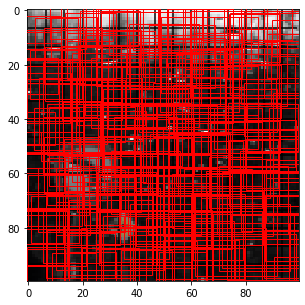

array([[[1.1929611 , 0.40922928, 0.46162486, 2.7853498 , 2.7175405 ],
        [1.1371458 , 0.5353353 , 0.5381315 , 2.6040258 , 2.4035084 ],
        [1.4091415 , 0.4429779 , 0.48121974, 2.7087216 , 2.5945022 ],
        ...,
        [1.4062681 , 0.49293533, 0.53294826, 3.2525172 , 3.0068228 ],
        [1.2914939 , 0.396813  , 0.4459285 , 3.1435065 , 3.1362658 ],
        [1.2240711 , 0.5430166 , 0.5493788 , 2.991682  , 2.7373528 ]],

       [[1.5064231 , 0.4651482 , 0.5129985 , 3.4019012 , 3.259594  ],
        [1.1828687 , 0.5577881 , 0.57206786, 2.41424   , 2.2458854 ],
        [1.4023821 , 0.51895344, 0.5578852 , 3.234056  , 2.9187238 ],
        ...,
        [1.2630063 , 0.47656226, 0.5027495 , 3.4624393 , 3.2320058 ],
        [1.4142438 , 0.54582775, 0.5702568 , 3.386155  , 3.046445  ],
        [1.369129  , 0.58336884, 0.5790237 , 3.3327131 , 3.0117307 ]],

       [[1.2034067 , 0.388585  , 0.45080897, 2.3754191 , 2.2914736 ],
        [1.1242722 , 0.5313594 , 0.5418865 , 2.5330484 , 2.3

In [20]:
cnn.predict(xTest[2])

In [159]:
K.eval(loss())

[[  -0.       -0.       -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0.     1735.4438   -0.
    -0.     1735.4438   -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0.       -0.       -0.
    -0.       -0.       -0.       -0.       -0. 

6942.1187

In [ ]:
showImageWithGrid(xTest[20], yTest[20])

In [54]:
cnn = cnn.clone()

## Test lost function

In [ ]:
def testLoss(yTrue, yPred):
    yTrue = K.reshape(yTrue, (K.shape(yTrue)[0], 3 * 3, 5))
    yPred = K.reshape(yPred, (K.shape(yPred)[0], 3 * 3, 5))
    objectMask = K.cast(K.greater(yTrue[..., 0], 0.5), 'float32')
    loss = 0
    
    m = K.shape(yPred)[0] 
    mask = tf.TensorArray('float32', size=1, dynamic_size=True)
    def calculateIOUS(i, mask):
        trueBox = tf.boolean_mask(yTrue, objectMask, axis=0)[i]
        score = ious(yPred[i], trueBox)
        best = K.max(score, axis=-1)
        mask = mask.write(i, K.cast(best < 0.5, 'float32'))
        return i + 1, mask
    tf.while_loop(lambda i, _: i < m, calculateIOUS, [0, mask])
        
    mask = mask.stack()
    loss += objectMask * K.sum(K.binary_crossentropy(yTrue[..., 1:3], yPred[..., 1:3]), axis=-1)
    loss += objectMask * K.sum(K.square(yTrue[..., 3:5] - yPred[..., 3:5]), axis=-1)
    loss += objectMask * K.binary_crossentropy(yTrue[..., 0], yPred[..., 0])
    #loss += (1 - objectMask) * mask * K.binary_crossentropy(yTrue[..., 0], yPred[..., 0])
    
    return loss

In [ ]:
testInput = np.array([[
    [[0, 0, 0, 0, 0], [0, 0, 0, 3, 1], [0, 1, 0, 3, 0]],
    [[1, 0.1, 0.5, 3.2, 1.2], [0, 0, 0.4, 4, 1], [0, 1, 0, 3, 0]],
    [[0, 0, 0, 0, 0], [0, 0.3, 0.4, 2, 1], [1, 0.7, 0.9, 3.2, 4.4]],
],
[
    [[0, 0, 0, 0, 0], [0, 0, 0, 3, 1], [0, 1, 0, 3, 0]],
    [[1, 0.1, 0.5, 3.2, 1.2], [0, 0, 0.4, 4, 1], [0, 1, 0, 3, 0]],
    [[0, 0, 0, 0, 0], [0, 0.3, 0.4, 2, 1], [1, 0.7, 0.9, 3.2, 4.4]],
]
])

testOutput =  np.array([[
    [[0, 0, 0, 0, 0], [0, 0, 0, 3, 1], [0, 1, 0, 3, 0]],
    [[1, 0.2, 0.5, 3.2, 1.2], [0, 0, 0.4, 4, 1], [0, 1, 0, 3, 0]],
    [[0, 0, 0, 0, 0], [0, 0.3, 0.4, 2, 1], [1, 0.7, 0.9, 3.2, 4.4]],
],
[
    [[0, 0, 0, 0, 0], [0, 0, 0, 3, 1], [0, 1, 0, 3, 0]],
    [[1, 0.1, 0.5, 3.2, 1.2], [0, 0, 0.4, 4, 1], [0, 1, 0, 3, 0]],
    [[0, 0, 0, 0, 0], [0, 0.3, 0.4, 2, 1], [1, 0.7, 0.9, 3.2, 4.4]],
]
])

In [ ]:
testInput.shape

In [ ]:
K.eval(K.sum(testLoss(K.variable(testInput), K.variable(testOutput))))

In [ ]:
testInput[..., 1]

In [ ]:
K.eval(K.binary_crossentropy(K.variable(testInput)[..., 1:3], K.variable(testOutput)[..., 1:3]))

## Prediction

In [ ]:
def iou (a, b):
    ax1, ax2, ay1, ay2 = a[0] - a[2] / 2, a[0] + a[2] / 2, a[1] - a[3] / 2, a[1] + a[3] / 2
    bx1, bx2, by1, by2 = b[0] - b[2] / 2, b[0] + b[2] / 2, b[1] - b[3] / 2, b[1] + b[3] / 2
    x1, x2 = max(ax1, bx1), min(ax2, bx2)
    y1, y2 = max(ay1, by1), min(ay2, by2)
    intersection = (x2 - x1) * (y2 - y1)
    union = a[2] * a[3] + b[2] * b[3] - intersection
    return intersection / union

## Saving the model

In [ ]:
model.save('models/model4.h5')

## Load model

In [ ]:
model = load_model('models/model4.h5')